In [63]:
from importlib import reload

import numpy as np
import pandas as pd
import scipy as sc
import torch

import assay
import designer
import dre
import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [22]:
reload(designer)
reload(assay)


fitness_str = 'blue'
n_bits = 8
order = 2
gamma = 1
lmbda = 4
n_train = 2000
n_design = 2000

# featurize all sequences in combinatorially complete dataset
data = assay.PoelwijkData(fitness_str, order=order, n_bits=n_bits)
print(data.Xsigned_nxp.shape)

# design sequences
ds = designer.RidgeEBMDesigner(data, gamma, lmbda)

Xtrain_nxp, ytrain_n, Xcal_nxp, ycal_n, lrcal_n, Xtest_mxp, ytest_m, pred_m, true_mean = ds.get_training_and_designed_data(
    n_train, n_design
) 

Using 37 order-2 features
Loading estimated measurement noise SD computed using order 7 and significance level 0.01
(8192, 8)


0.6783207936099472


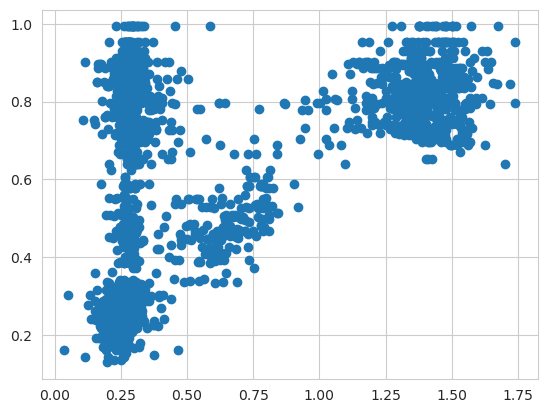

In [23]:
plt.scatter(ytest_m, pred_m);
print(true_mean)

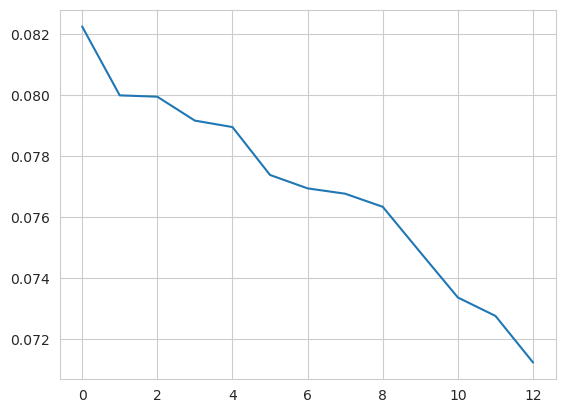

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
Xpc_nx = pca.fit_transform(np.vstack([Xtrain_nxp[:, 1 : 14], Xtest_mxp[:, 1 : 14]]))
plt.plot(pca.explained_variance_ratio_)

|    |   dre_best_loss |   dre_last_train_loss |   dre_tgt_loss |
|---:|----------------:|----------------------:|---------------:|
|  0 |            0.55 |                0.5512 |         0.6932 |


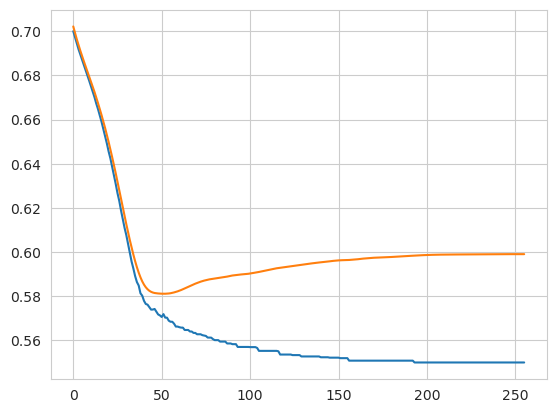

In [27]:
reload(dre)


def display_metrics(metrics):
    df = pd.DataFrame((metrics,)).round(4)
    print(df.to_markdown())

cfg = {
    'lr': 1e-3,
    'weight_decay': 0,
    'num_grad_steps': 256,
    'noise_aug_scale': 0.1,
    'ema_weight': 1,
}
val_frac = 0.1
n_hidden = 64

Xsource_xp = Xtrain_nxp
Xtarget_xp = Xtest_mxp

re = dre.RatioEstimator(in_size=Xsource_xp.shape[1], n_hidden=n_hidden)
metrics, df = dre.fit_dr_estimator(cfg, re, Xsource_xp, Xtarget_xp, val_frac=val_frac)

display_metrics(metrics)
plt.plot(df['train_loss']);
plt.plot(df['val_loss']);

[0.99937767 0.9993791 ]
0.44469735035810315 0.44497379911458984 0.693704837281208 0.6783207936099472 0.6776767464710133


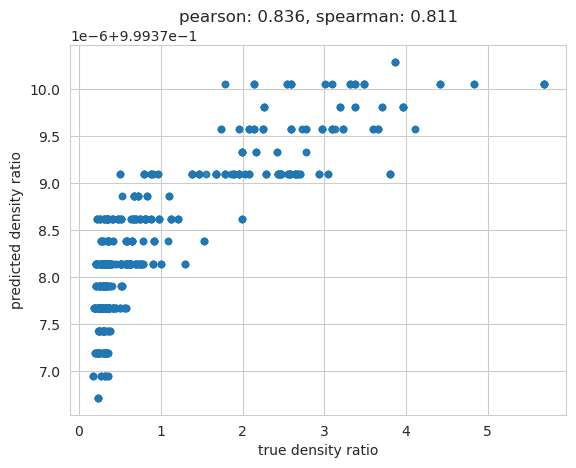

In [26]:
lrpredcal_n = re(torch.Tensor(Xcal_nxp))
lrpredcal_n2 = np.array(re(torch.Tensor(Xcal_nxp)))

lrpredcal_n = np.array(lrpredcal_n)
print(lrpredcal_n[: 2])
plt.scatter(lrcal_n, lrpredcal_n, alpha=0.5, s=20);
plt.xlabel('true density ratio');
plt.ylabel('predicted density ratio');
r, p = sc.stats.pearsonr(lrcal_n, lrpredcal_n)
rho, p = sc.stats.spearmanr(lrcal_n, lrpredcal_n)

print(np.mean(lrpredcal_n * ycal_n), np.mean(ycal_n), np.mean(lrcal_n * ycal_n), true_mean, np.mean(pred_m))

plt.title('pearson: {:.3f}, spearman: {:.3f}'.format(r, rho));

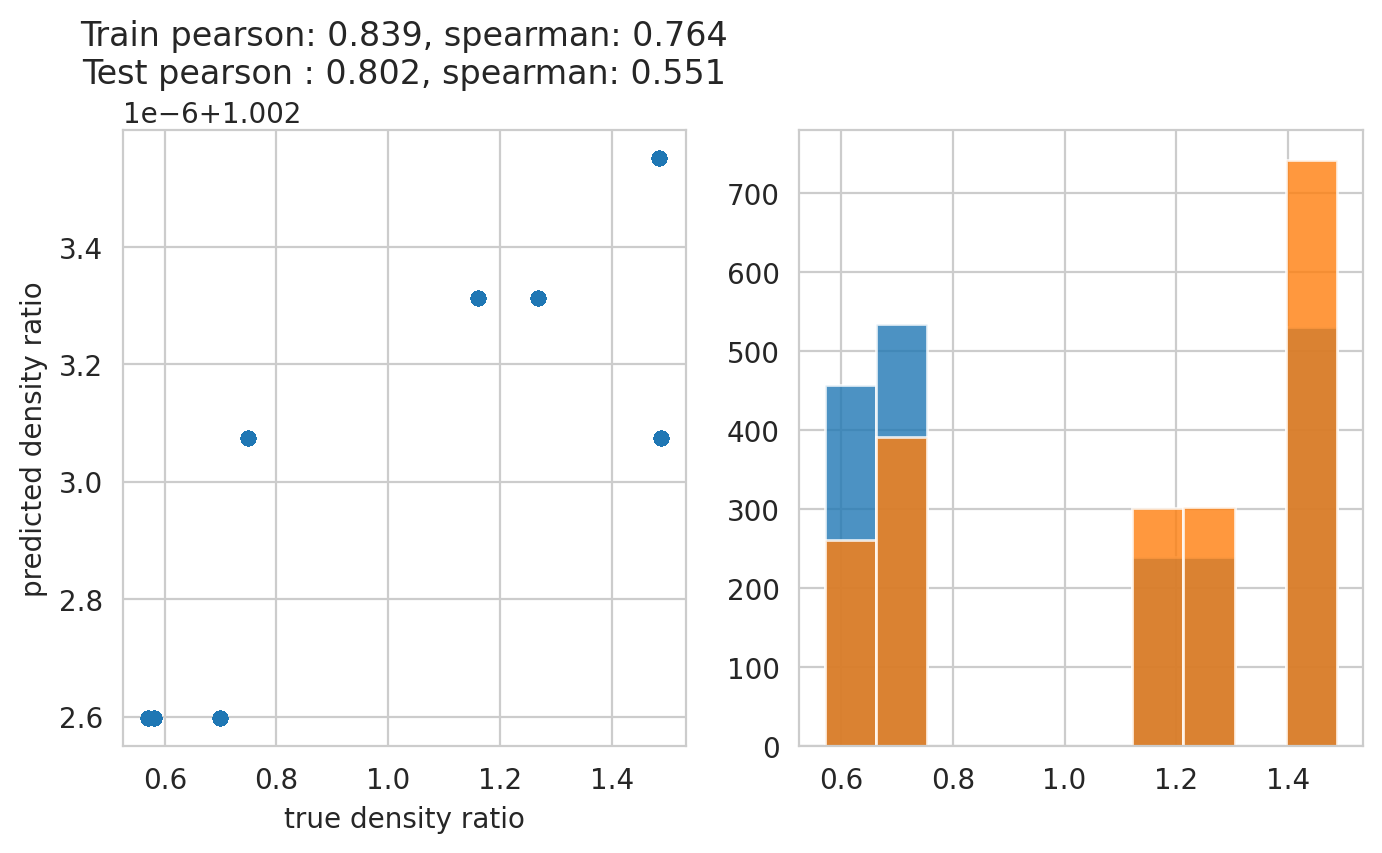

In [21]:
tXtr_nxp = torch.Tensor(Xtrain_nxp)
tXte_nxp = torch.Tensor(Xtest_mxp)

lrpredtr_n = re(tXtr_nxp)
lrtr_n = ds.get_lrs(Xtrain_nxp)
lrpredte_n = re(tXte_nxp)
lrte_n = ds.get_lrs(Xtest_mxp)

plt.figure(figsize=(8, 4), dpi=200)
plt.subplot(121)
plt.scatter(lrtr_n, lrpredtr_n, alpha=0.5, s=20);
plt.xlabel('true density ratio');
plt.ylabel('predicted density ratio');
rtr, p = sc.stats.pearsonr(lrtr_n, lrpredtr_n)
rhotr, p = sc.stats.spearmanr(lrtr_n, lrpredtr_n)

plt.scatter(lrte_n, lrpredte_n, alpha=0.5, s=20);
plt.xlabel('true density ratio');
plt.ylabel('predicted density ratio');
rte, p = sc.stats.pearsonr(lrte_n, lrpredte_n, )
rhote, p = sc.stats.spearmanr(lrte_n, lrpredte_n, )
plt.title('Train pearson: {:.3f}, spearman: {:.3f}\nTest pearson : {:.3f}, spearman: {:.3f}'.format(
    rtr, rhotr, rte, rhote));

plt.subplot(122)
plt.hist(lrtr_n, alpha=0.8);
plt.hist(lrte_n, alpha=0.8);

# 1-D problem

In [76]:
import torch
import copy

In [77]:
def get_log_ratio(x, a, b):
    return b - np.exp(a) * np.square(x)

def get_data(n, sigma1, sigma2):
    x1_n = sc.stats.norm.rvs(loc=0, scale=sigma1, size=n)
    x2_n = sc.stats.norm.rvs(loc=0, scale=sigma2, size=n)
    xcal_n = sc.stats.norm.rvs(loc=0, scale=sigma1, size=n)
    a_true = np.log(1 / (2 * sigma1 ** 2) - 1 / (2 * sigma2 ** 2))
    b_true = np.log(sigma2 / sigma1)
    lr1_n = get_log_ratio(x1_n, a_true, b_true)
    lrcal_n = get_log_ratio(xcal_n, a_true, b_true)
    lr2_n = get_log_ratio(x2_n, a_true, b_true)
    return x1_n, lr1_n, xcal_n, lrcal_n, x2_n, lr2_n, a_true, b_true

class ClosedFormDR(torch.nn.Module):
    def __init__(self, a_true=None, b_true=None):
        super().__init__()
        if a_true is None:
            self.a = torch.nn.Parameter(torch.randn(()))  # TODO initialize better?
        else:
            self.a = torch.nn.Parameter(torch.tensor(a_true))
        if b_true is None:
            self.b = torch.nn.Parameter(torch.randn(()))  # TODO initialize better?
        else:
            self.b = b_true  # torch.nn.Parameter(torch.tensor(b_true))
        print('Initialized a = {} and b = {}'.format(self.a.item(), self.b.item()))

    def forward(self, x):
        return self.b - torch.exp(self.a) * torch.square(x)

class LogRatioEstimator(torch.nn.Module):
    def __init__(self, lr=1e-3, weight_decay=0, n_steps: int = 256, a_true=None, b_true=None):
        super().__init__()

        self.classifier = torch.nn.Sequential(
            ClosedFormDR(a_true=a_true, b_true=b_true),
        )
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.n_steps = n_steps
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_steps = n_steps
        
    def forward(self, x):
        return self.classifier(x).squeeze(-1)
    
    def fit(self, x1_n, x2_n, val_frac: float = 0.1):
        tx1_nx1 = torch.Tensor(x1_n[:, None])
        tx2_nx1 = torch.Tensor(x2_n[:, None])
        n = x1_n.size

        z1 = torch.zeros((n), 1)
        z2 = torch.ones((n), 1) 
        x_all = torch.cat([tx1_nx1, tx2_nx1])
        z_all = torch.cat([z1, z2])

        if val_frac:
            n_val = int(val_frac * 2 * n)
            rand_perm = np.random.permutation(2 * n)
            xval_x1 = x_all[rand_perm[:n_val]]
            zval_x1 = z_all[rand_perm[:n_val]]
            xtr_nx1 = x_all[rand_perm[n_val:]]
            ztr_nx1 = z_all[rand_perm[n_val:]]
        else:
            n_val = 0
            xtr_nx1 = x_all
            ztr_nx1 = z_all
            xval_x1 = None
            zval_x1 = None

        loss_fn = torch.nn.BCEWithLogitsLoss()
        self.classifier.requires_grad_(True)
        # optim = torch.optim.Adam(self.classifier.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        optim = torch.optim.SGD(self.classifier.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        best_loss = float('inf')
        losses = []
        val_loss = 0

        for _ in range(self.n_steps):
            if n_val:
                with torch.no_grad():
                    val_logits = self.classifier(xval_x1)
                    val_loss = loss_fn(val_logits, zval_x1)

            self.classifier.zero_grad()
            train_logits = self.classifier(xtr_nx1)
            train_loss = loss_fn(train_logits, ztr_nx1)

            if n_val and val_loss < best_loss:
                best_loss = val_loss.item()
                best_weights = copy.deepcopy(self.classifier.state_dict())
                ckpt_train_loss = train_loss.item()
            elif train_loss < best_loss:
                best_loss = train_loss.item()
                best_weights = copy.deepcopy(self.classifier.state_dict())
                ckpt_train_loss = train_loss.item()

            train_loss.backward()
            optim.step()
            losses.append([ckpt_train_loss, val_loss.item()])

        self.classifier.load_state_dict(best_weights)
        self.classifier.requires_grad_(False)
        df = pd.DataFrame(losses, columns=["train_loss", "val_loss"])
        return df

3.9019726695746444 2.302585092994046


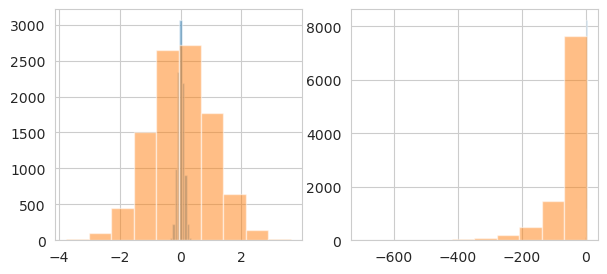

In [82]:
n = 10000
sigma1 = 0.1
sigma2 = 1
x1_n, lr1_n, xcal_n, lrcal_n, x2_n, lr2_n, a_true, b_true = get_data(n, sigma1, sigma2)
print(a_true, b_true)

plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.hist(x1_n, alpha=0.5);
plt.hist(x2_n, alpha=0.5);
plt.subplot(122)
plt.hist(lr1_n, alpha=0.5);
plt.hist(lr2_n, alpha=0.5);

Initialized a = 0.726990818977356 and b = 2.302585092994046
None tensor(-3.9333)


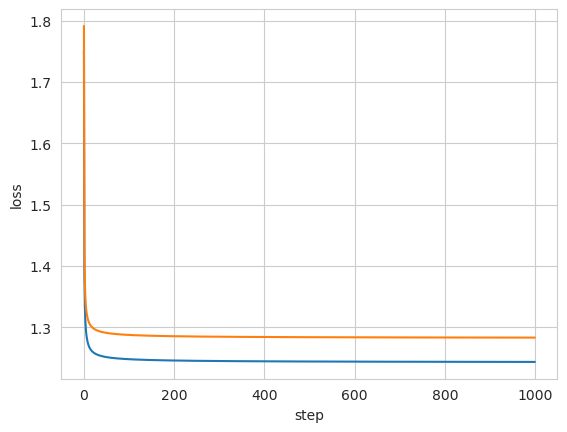

In [83]:
lr = 1
weight_decay = 0
n_steps = 1000
lre = LogRatioEstimator(lr=lr, weight_decay=weight_decay, n_steps=n_steps, b_true=b_true)
df = lre.fit(x1_n, x2_n)
plt.plot(df['train_loss']);
plt.plot(df['val_loss']);
plt.xlabel('step');
plt.ylabel('loss');
for p in lre.classifier.parameters():
    print(p.name, p.data)

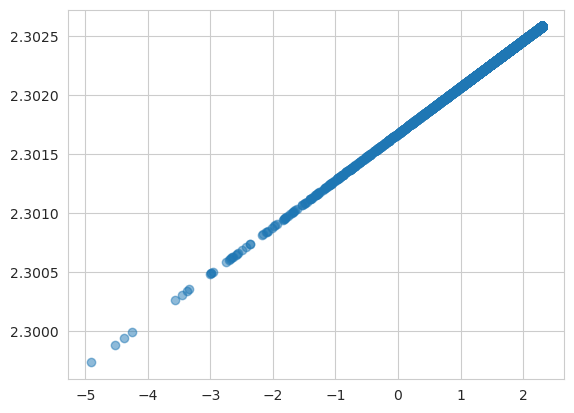

In [84]:
lrpred1_n = lre(torch.tensor(x1_n))
lrpred2_n = lre(torch.tensor(x2_n))
lrpredcal_n = lre(torch.tensor(xcal_n))


# plt.scatter(lr1_n, lrpred1_n, alpha=0.5);
# plt.scatter(lr2_n, lrpred2_n, alpha=0.5);
plt.scatter(lrcal_n, lrpredcal_n, alpha=0.5);

# multivariate gaussian